In [1]:
import time
import requests
import pandas as pd

### SQUIDGAME 1 REVIEWS

#### Extract

In [2]:
squid_1_reviews = []

In [3]:
baseurl = "https://www.rottentomatoes.com/napi/season/c156dad3-ec06-3b36-8dd6-9368b41284e4/reviews/user?after="
baseurl_before = "https://www.rottentomatoes.com/napi/season/c156dad3-ec06-3b36-8dd6-9368b41284e4/reviews/user?before="
center_cursor = "eyJyZWFsbV91c2VySWQiOiJSVF8zMGM4MzgxNi05M2ExLTQxYjItYTYyNS1kN2RlZWQxNTk2OGMiLCJlbXNJZCI6ImMxNTZkYWQzLWVjMDYtM2IzNi04ZGQ2LTkzNjhiNDEyODRlNCIsImVtc0lkX2hhc1Jldmlld0lzVmlzaWJsZSI6ImMxNTZkYWQzLWVjMDYtM2IzNi04ZGQ2LTkzNjhiNDEyODRlNF9UIiwiY3JlYXRlRGF0ZSI6IjIwMjUtMDEtMDVUMTQ6NTA6MzguNDc3WiJ9"
pageCount = 200

In [4]:
end_cursor = center_cursor
while True:
    response = requests.get(baseurl + end_cursor + "&pageCount=" + str(pageCount))
    time.sleep(0.1)
    squid_1_reviews.extend(response.json()['reviews'])
    print(f'{len(response.json()['reviews'])} reviews added : total {len(squid_1_reviews)}')
    if not response.json()['pageInfo']['hasNextPage']:
        break
    else:
        end_cursor = response.json()['pageInfo']['endCursor']


200 reviews added : total 200
200 reviews added : total 400
200 reviews added : total 600
200 reviews added : total 800
200 reviews added : total 1000
99 reviews added : total 1099


In [5]:
end_cursor = center_cursor
while True:
    response = requests.get(baseurl_before + end_cursor + "&pageCount=" + str(pageCount))
    time.sleep(0.1)
    squid_1_reviews.extend(response.json()['reviews'])
    print(f'{len(response.json()['reviews'])} reviews added : total {len(squid_1_reviews)}')
    if not response.json()['pageInfo']['hasPreviousPage']:
        break
    else:
        end_cursor = response.json()['pageInfo']['endCursor']

19 reviews added : total 1118


In [6]:
squid_1_df = pd.DataFrame(squid_1_reviews)

In [7]:
squid_1_df.describe()

,rating,score
count,1118.000000,1118.000000
mean,3.916369,3.916369
std,1.329855,1.329855
min,0.500000,0.500000
25%,3.500000,3.500000
50%,4.500000,4.500000
75%,5.000000,5.000000
max,5.000000,5.000000


In [8]:
squid_1_df.to_csv('squid_1_reviews.csv')

#### Transform

In [147]:
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt
from collections import Counter

In [132]:
squid_1_df = pd.read_csv('data/squid_1_reviews.csv')
squid_1_df['quote'] = squid_1_df['quote'].str.replace('\n', ' ')

In [148]:
delimiter = 2.0
positive_reviews_s1 = squid_1_df[squid_1_df['rating'] >= delimiter]
negative_reviews_s1 = squid_1_df[squid_1_df['rating'] < delimiter]
positive_review_text_s1 = ' '.join(positive_reviews_s1['quote'])
negative_review_text_s1 = ' '.join(negative_reviews_s1['quote'])

In [221]:
unwanted_pos = [
    'DT',    # Determiner (한정사): 예 - "the", "a", "an"
    'WDT',   # Wh-determiner (관계대명사): 예 - "which", "that"
    'PRP',   # Personal Pronoun (인칭 대명사): 예 - "I", "he", "she", "they"
    'PRP$',  # Possessive Pronoun (소유 대명사): 예 - "my", "your", "his", "her"
    'IN',    # Preposition/Subordinating Conjunction (전치사/종속 접속사): 예 - "in", "on", "with", "because"
    'RB',    # Adverb (부사): 예 - "quickly", "very", "happily"
    'RBR',   # Adverb, Comparative (비교급 부사): 예 - "faster", "better"
    'RBS',   # Adverb, Superlative (최상급 부사): 예 - "fastest", "best"
    'CC',    # Coordinating Conjunction (등위 접속사): 예 - "and", "or", "but"
    'MD',    # Modal Verb (조동사): 예 - "can", "could", "shall", "should"
    'VB',    # Verb, Base Form (동사, 기본형): 예 - "run", "go", "be"
    'VBD',   # Verb, Past Tense (동사, 과거형): 예 - "ran", "went", "was"
    'VBG',   # Verb, Gerund/Present Participle (동사, 현재분사): 예 - "running", "going"
    'VBN',   # Verb, Past Participle (동사, 과거분사): 예 - "gone", "been"
    'VBP',   # Verb, Present Tense, Non-3rd Person Singular (동사, 현재형, 3인칭 제외): 예 - "run", "am"
    'VBZ',   # Verb, Present Tense, 3rd Person Singular (동사, 현재형, 3인칭 단수): 예 - "runs", "is", "has"
    'EX',     # Existential There (존재를 나타내는 there): 예 - "There is a book."
    '.', ',', ':', '(', ')', '``', "''"
]
meaningful_tags = [
        'NN', 'NNS', 'NNP', 'NNPS',  # 명사류
        # 'JJ', 'JJR', 'JJS',          # 형용사류
        # 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'  # 동사류
    ]

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    # 필터링 (명사와 형용사만 포함)
    filtered_words = [word for word, tag in tagged_tokens if tag not in unwanted_pos and word not in nltk_stopwords.words('english')]
    # filtered_words = [word for word, tag in tagged_tokens if tag in meaningful_tags and word not in nltk_stopwords.words('english')]
    return ' '.join(filtered_words)

##### 공통된 단어들 제거

In [222]:
removed_pos_review_text_s1 = remove_stopwords(positive_review_text_s1)
removed_neg_review_text_s1 = remove_stopwords(negative_review_text_s1)
pos_review_count_s1 = Counter(removed_pos_review_text_s1.lower().split())
neg_review_count_s1 = Counter(removed_neg_review_text_s1.lower().split())
pos_review_set = set([word for word, cnt in pos_review_count_s1.most_common(20)])
neg_review_set = set([word for word, cnt in neg_review_count_s1.most_common(20)])
print(pos_review_set & neg_review_set)

{'games', 'game', 'show', 'time', 'character', 'characters', 'good', 'story', "'s", 'plot', 'series', 'people'}


In [223]:
pos_wc_s1 = WordCloud(width=1000, height=500, background_color='white', stopwords=pos_review_set & neg_review_set, min_word_length= 3).generate(remove_stopwords(positive_review_text_s1))
pos_wc_s1.to_file('squid_1_positive_wordcloud.png')
neg_wc_s1 = WordCloud(width=1000, height=500, background_color='white', stopwords=pos_review_set & neg_review_set, min_word_length= 3).generate(remove_stopwords(negative_review_text_s1))
neg_wc_s1.to_file('squid_1_negative_wordcloud.png')

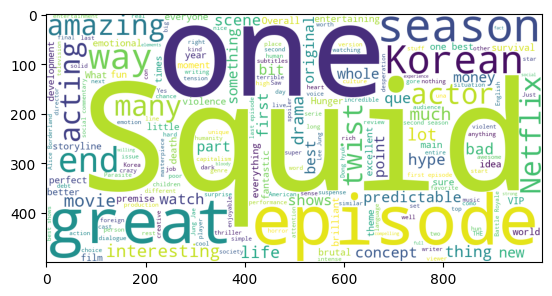

In [224]:
plt.imshow(pos_wc_s1)

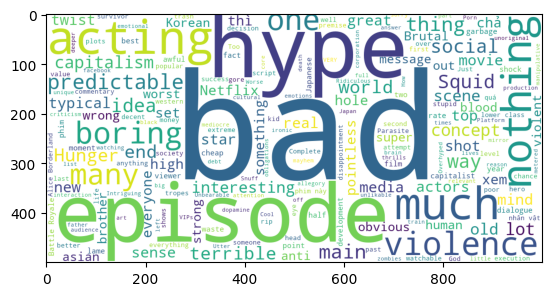

In [225]:
plt.imshow(neg_wc_s1)

### SQUIDGAME 2 REVIEWS

#### Extract

In [54]:
reviews_squidgame_2 = []

In [55]:
baseurl = "https://www.rottentomatoes.com/napi/season/3f0a0478-c57a-3fc6-8ec1-e4dd8f1e41fb/reviews/user?after="

baseurl_before = "https://www.rottentomatoes.com/napi/season/3f0a0478-c57a-3fc6-8ec1-e4dd8f1e41fb/reviews/user?before="
center_cursor = "eyJyZWFsbV91c2VySWQiOiJSVF82ZTk3MjdhMy05Y2RkLTQ3ZDAtODI4OS05NzM3YjU5M2QzZWYiLCJlbXNJZCI6IjNmMGEwNDc4LWM1N2EtM2ZjNi04ZWMxLWU0ZGQ4ZjFlNDFmYiIsImVtc0lkX2hhc1Jldmlld0lzVmlzaWJsZSI6IjNmMGEwNDc4LWM1N2EtM2ZjNi04ZWMxLWU0ZGQ4ZjFlNDFmYl9UIiwiY3JlYXRlRGF0ZSI6IjIwMjUtMDEtMTNUMjM6NDQ6MjkuOTEwWiJ9"
pageCount = 200

In [56]:
end_cursor = center_cursor
while True:
    response = requests.get(baseurl + end_cursor + "&pageCount=" + str(pageCount))
    time.sleep(0.1)
    reviews_squidgame_2.extend(response.json()['reviews'])
    print(f'{len(response.json()['reviews'])} reviews added : total {len(reviews_squidgame_2)}')
    if not response.json()['pageInfo']['hasNextPage']:
        break
    else:
        end_cursor = response.json()['pageInfo']['endCursor']


200 reviews added : total 200
200 reviews added : total 400
200 reviews added : total 600
200 reviews added : total 800
129 reviews added : total 929


In [57]:
end_cursor = center_cursor
while True:
    response = requests.get(baseurl_before + end_cursor + "&pageCount=" + str(pageCount))
    time.sleep(0.1)
    reviews_squidgame_2.extend(response.json()['reviews'])
    print(f'{len(response.json()['reviews'])} reviews added : total {len(reviews_squidgame_2)}')
    if not response.json()['pageInfo']['hasPreviousPage']:
        break
    else:
        end_cursor = response.json()['pageInfo']['endCursor']

19 reviews added : total 948


In [59]:
squid_2_df = pd.DataFrame(reviews_squidgame_2)

In [60]:
squid_2_df.describe()

,rating,score
count,948.000000,948.000000
mean,3.315928,3.315928
std,1.678056,1.678056
min,0.500000,0.500000
25%,1.500000,1.500000
50%,4.000000,4.000000
75%,5.000000,5.000000
max,5.000000,5.000000


In [61]:
squid_2_df.to_csv('squid_2_reviews.csv')

#### Transform

In [212]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt

In [213]:
squid_2_df = pd.read_csv('data/squid_2_reviews.csv')

In [214]:
squid_2_df['quote'] = squid_2_df['quote'].str.replace('\n', ' ')

In [215]:
delimiter = 2.0
positive_reviews_s2 = squid_2_df[squid_2_df['rating'] >= delimiter]
negative_reviews_s2 = squid_2_df[squid_2_df['rating'] < delimiter]
positive_review_text_s2 = ' '.join(positive_reviews_s2['quote'])
negative_review_text_s2 = ' '.join(negative_reviews_s2['quote'])

##### 공통된 단어들 제거

In [216]:
removed_pos_review_text_s2 = remove_stopwords(positive_review_text_s2)
removed_neg_review_text_s2 = remove_stopwords(negative_review_text_s2)
pos_review_count_s2 = Counter(removed_pos_review_text_s2.lower().split())
neg_review_count_s2 = Counter(removed_neg_review_text_s2.lower().split())
pos_review_set = set([word for word, cnt in pos_review_count_s1.most_common(20)])
neg_review_set = set([word for word, cnt in neg_review_count_s1.most_common(20)])
print(pos_review_set & neg_review_set)

{'games', 'acting', 'game', 'show', 'time', 'character', 'characters', 'story', 'plot', 'episode', 'series', 'people'}


In [217]:
pos_wc_s2 = WordCloud(width=1000, height=500, background_color='white', stopwords=pos_review_set & neg_review_set, min_word_length= 3).generate(remove_stopwords(positive_review_text_s2))
pos_wc_s2.to_file('squid_2_positive_wordcloud.png')
neg_wc_s2 = WordCloud(width=1000, height=500, background_color='white', stopwords=pos_review_set & neg_review_set, min_word_length= 3).generate(remove_stopwords(negative_review_text_s2))
neg_wc_s2.to_file('squid_2_negative_wordcloud.png')

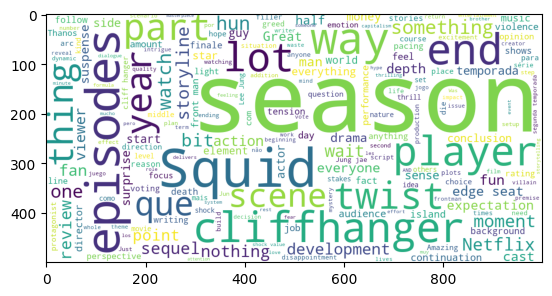

In [218]:
plt.imshow(pos_wc_s2)

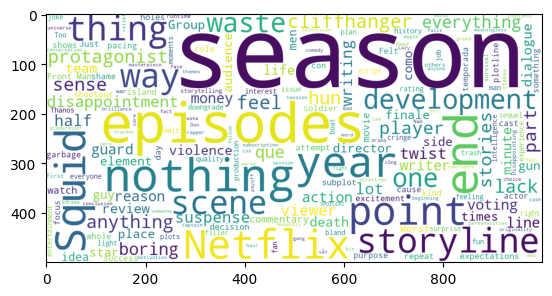

In [219]:
plt.imshow(neg_wc_s2)